In [1]:
#Importing Libraries
#Data Handling
import pandas as pd
import numpy as np
import sklearn
import math
import random

import sys
sys.path.append('Write here the directory path of Code Supplementary Materil folder')

from source import *
import source.fairness as fm
import source.pipes as op
import source.utils as ut
from source.estimators import FORESEE

#Storing trains
import pickle

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
#Run following codes for loading pipelines on dictionary from pickles
with open('../../pipes/adult-income/fairness/preprocessing.pickle', 'rb') as f:
    preprocessing_pickles = pickle.load(f)

with open('../../pipes/adult-income/fairness/preprocessing_norm.pickle', 'rb') as f:
    preprocessing_pickles_norm = pickle.load(f)
    
with open('../../pipes/adult-income/fairness/y.pickle', 'rb') as f:
    y = pickle.load(f)
    
with open('../../pipes/adult-income/fairness/preprocessing_test.pickle', 'rb') as f:
    data_test_prepro = pickle.load(f)
    
with open('../../pipes/adult-income/fairness/preprocessing_test_norm.pickle', 'rb') as f:
    data_test_prepro_norm = pickle.load(f)
    
with open('../../pipes/adult-income/fairness/A.pickle', 'rb') as f:
    A = pickle.load(f)
    
with open('../../pipes/adult-income/fairness/preprocessing_features_aware.pickle', 'rb') as f:
    aware_features = pickle.load(f)
    
with open('../../pipes/adult-income/fairness/preprocessing_features_sex.pickle', 'rb') as f:
    gender_features = pickle.load(f)


In [3]:
#Run this for creating dictionary of datasets, nompipelines, and numpipelines
#remember: transf means data normalized and scaled.
datasets_prepro = {}
datasets_prepro_norm = {}
pipes_nominal = {}
pipes_numerical = {}

for p in preprocessing_pickles_norm:
    d , pnom, pnum = preprocessing_pickles_norm[p]
    datasets_prepro_norm[p] = d

for p in preprocessing_pickles:
    d , pnom, pnum = preprocessing_pickles[p]
    datasets_prepro[p] = d
    pipes_nominal[p] = pnom
    pipes_numerical[p] = pnum
    
for yval in y:
    y_train = y['train']
    y_test = y['test']
    
for Aval in A:
    A_train = A['train']
    A_test = A['test']
    
#Get in a dictionary all preprocessed datasets.
datasets_train = {}
for d in datasets_prepro:
    ds = datasets_prepro[d]
    datasets_train[d] = ds
    
datasets_norm_train = {}
for d in datasets_prepro_norm:
    ds = datasets_prepro_norm[d]
    datasets_norm_train[d] = ds
    
#Get in a dictionary all preprocessed datasets.
datasets_test = {}
for d in data_test_prepro:
    ds = data_test_prepro[d]
    datasets_test[d] = ds
datasets_test.keys()

datasets_norm_test = {}
for d in data_test_prepro_norm:
    ds = data_test_prepro_norm[d]
    datasets_norm_test[d] = ds
datasets_norm_test.keys()


dict_keys(['aware', 'sex'])

In [4]:
X_t = datasets_train['sex'].toarray()
A_t = np.array(A_train['sex'])
y_t = y_train.to_numpy().reshape(-1)

X_prueba = np.concatenate((X_t, 1*(A_t==' Female').reshape(-1,1)), axis=1)

In [39]:
fsee= FORESEE(min_samples_leaf=[2])
fsee.fit(X=X_prueba,
         A=A_t,
         priv_class=' Male',
         y=y_t,
         scoring = ['accuracy'])

Complete                    

In [79]:
with open('checkpoints/fsee.pickle', 'wb') as f:
    pickle.dump(fsee, f, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('checkpoints/fsee.pickle', 'rb') as f:
    fsee = pickle.load(f)

In [8]:
risks_train, disc_acc_train, count_disc_train = fsee.risk_disc(X=X_prueba,
                                                               y=y_t,
                                                               A=A_t,
                                                               priv_class=' Male', 
                                                               beta=0.61)


In [9]:
X_tt  = datasets_test['sex'].toarray()
A_tt = np.array(A_test['sex'])
y_tt = y_test.to_numpy().reshape(-1)


X_prueba_test = np.concatenate((X_tt, 1*(A_tt==' Female').reshape(-1,1)), axis=1)

In [10]:
risks_test, disc_acc_test, count_disc_test = fsee.risk_disc(X=X_prueba_test,
                                                            y=y_tt,
                                                            A=A_tt,
                                                            priv_class=' Male', 
                                                            beta=0.61)


In [11]:
#checkpoints
with open('checkpoints/risks_train.pickle', 'wb') as f:
    pickle.dump(risks_train, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('checkpoints/risks_test.pickle', 'wb') as f:
    pickle.dump(risks_test, f, protocol=pickle.HIGHEST_PROTOCOL)

# Analayzing Results

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


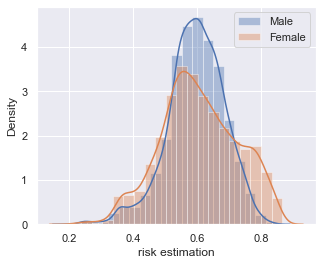

In [158]:
plt.figure(figsize=(5, 4))
sns.distplot(risks_test['th_beta'][A_tt==' Male'], hist=True, kde=True, bins=20, label='Male')
sns.distplot(risks_test['th_beta'][A_tt==' Female'], hist=True, kde=True, bins=20, label='Female')
plt.xlabel('risk estimation')
plt.legend()
plt.show()

# Models

In [14]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [15]:
#Obtain the X, Y and risk
X_train_models = datasets_norm_train['aware'].toarray()
X_test_models = datasets_norm_test['aware'].toarray()

In [16]:
parameters = {'LR__C':[0.01, 0.1, 1], 'LR__fit_intercept':[True, False], 'LR__solver': ['liblinear','lbfgs'], 'LR__class_weight': [None,'balanced'], 'LR__max_iter' : [100000]}
lr = LogisticRegression(random_state=0)

fit_lr = op.get_grid(X_train_models, y_t, parameters, lr, 'LR', scoring=['f1'], refit='f1')


In [17]:
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}
rf = RandomForestClassifier(random_state=0)

fit_rf = op.get_grid(X_train_models, y_t, parameters, rf, 'RF', scoring=['f1'], refit='f1')


In [18]:
parameters = {'KNN__weights': ['uniform', 'distance'],'KNN__n_neighbors': [5, 10, 15, 20, 25, 30]}
knn = KNeighborsClassifier()

fit_knn = op.get_grid(X_train_models, y_t, parameters, knn, 'KNN', scoring=['f1'], refit='f1')
        

In [19]:
parameters = {'SVM__probability':[True],'SVM__kernel':['rbf', 'sigmoid'], 'SVM__C': [0.001, 0.01, 1, 10, 100], 'SVM__class_weight': [None,'balanced']}
svm = SVC(random_state=0)

fit_svm = op.get_grid(X_train_models, y_t, parameters, svm, 'SVM', scoring=['f1'], refit='f1')


In [20]:
models = {'LR': fit_lr,
          'RF': fit_rf,
          'KNN': fit_knn,
           'SVM': fit_svm}


In [21]:
models_results = pd.DataFrame(columns=['model','performance','eq_opp','eq_odd','dem_p'])

for m in models:
    clf = models[m].best_estimator_[m]
    y_pred = clf.predict(X_test_models)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, ' Male')
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, ' Male')
    dem_p = fm.demographic_parity_dif(y_pred, A_tt,' Male')

    new_r = {'model': m,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results = models_results.append(new_r, ignore_index=True)
models_results

,model,performance,eq_opp,eq_odd,dem_p
0,LR,0.618472,-0.409657,0.321224,-0.351572
1,RF,0.703699,-0.200369,0.208051,-0.331891
2,KNN,0.644371,-0.208270,0.148633,-0.199905
3,SVM,0.666094,-0.212210,0.247398,-0.382730


In [22]:
with open('checkpoints/models.pickle', 'wb') as f:
    pickle.dump(models, f, protocol = pickle.HIGHEST_PROTOCOL)

In [159]:
threshold = .5#risks_test['total'].mean(where=False==np.isnan(risks_test['total']))+risks_test['total'].std(where=False==np.isnan(risks_test['th_both']))

X_train_high = X_train_models[risks_train['th_beta']>=threshold]
y_train_high = y_t[risks_train['th_beta']>=threshold]
A_train_high = A_t[risks_train['th_beta']>=threshold]

X_train_low = X_train_models[risks_train['th_beta']<threshold]
y_train_low = y_t[risks_train['th_beta']<threshold]
A_train_low = A_t[risks_train['th_beta']<threshold]

X_test_high = X_test_models[risks_test['th_beta']>=threshold]
y_test_high = y_tt[risks_test['th_beta']>=threshold]
A_test_high = A_tt[risks_test['th_beta']>=threshold]

X_test_low = X_test_models[risks_test['th_beta']<threshold]
y_test_low = y_tt[risks_test['th_beta']<threshold]
A_test_low = A_tt[risks_test['th_beta']<threshold]


In [152]:
threshold

0.5

In [160]:
models_results_both = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['high','low']

for s in scenario:
    if s == 'high':
        X_test_model = X_test_high
        y_test_model = y_test_high
        A_test_model = A_test_high
    else:
        X_test_model = X_test_low
        y_test_model = y_test_low
        A_test_model = A_test_low
        
    clf =  models['RF'].best_estimator_['RF']
    y_pred = clf.predict(X_test_model)

    perfo = fm.f1score(y_test_model, y_pred)
    eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, ' Male')
    eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, ' Male')
    dem_p = fm.demographic_parity_dif(y_pred, A_test_model,' Male')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_both = models_results_both.append(new_r, ignore_index=True)
models_results_both

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,high,0.696105,-0.246217,0.247214,-0.372449
1,RF,low,0.817490,0.026067,0.028927,-0.040882


## Mitigation

### Removing risky samples from dataset
So no risky samples in training neither testing

In [167]:
rf = RandomForestClassifier(random_state=0)
parameters = {'RF__class_weight': ['balanced'],'RF__n_estimators':[10, 50, 100], 'RF__criterion': ['gini', 'entropy'], 'RF__max_depth': [None, 5, 10, 15]}


fit_rf_low = op.get_grid(X_train_low, y_train_low, parameters, rf, 'RF', scoring=['f1'], refit='f1')


In [168]:
models_scenario = {'overall': fit_rf, 'rem_high':fit_rf_low, 'rem_high_test':fit_rf}

models_results_rem = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['overall','rem_high','rem_high_test']

for s in scenario:
    if s == 'overall':
        X_test_model = X_test_models
        y_test_model = y_tt
        A_test_model = A_tt
    else:
        X_test_model = X_test_low
        y_test_model = y_test_low
        A_test_model = A_test_low
        
    clf = models_scenario[s].best_estimator_['RF']
    y_pred = clf.predict(X_test_model)

    perfo = fm.f1score(y_test_model, y_pred)
    eq_opp = fm.equal_opp_dif(y_test_model, y_pred, A_test_model, ' Male')
    eq_odd = fm.equalized_odd_dif(y_test_model, y_pred, A_test_model, ' Male')
    dem_p = fm.demographic_parity_dif(y_pred, A_test_model,' Male')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_rem = models_results_rem.append(new_r, ignore_index=True)
models_results_rem

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,overall,0.703699,-0.200369,0.208051,-0.331891
1,RF,rem_high,0.794224,-0.024306,0.033450,-0.056361
2,RF,rem_high_test,0.817490,0.026067,0.028927,-0.040882


### Implementing post-processing approahces

In [29]:
from fairlearn.postprocessing import ThresholdOptimizer

RF_best = fit_rf.best_estimator_['RF']

postprocess_est_eqODD = ThresholdOptimizer(
    estimator=RF_best,
    constraints="equalized_odds",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

postprocess_est_demP = ThresholdOptimizer(
    estimator=RF_best,
    constraints="demographic_parity",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

postprocess_est_eqOPP = ThresholdOptimizer(
    estimator=RF_best,
    constraints="true_positive_rate_parity",
    objective = 'balanced_accuracy_score',
    prefit=False,
    flip=True)

In [149]:
postprocess_est_eqODD.fit(X_train_models, y_t, sensitive_features=A_t)
postprocess_est_demP.fit(X_train_models, y_t, sensitive_features=A_t)
postprocess_est_eqOPP.fit(X_train_models, y_t, sensitive_features=A_t)


ThresholdOptimizer(constraints='true_positive_rate_parity',
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=15,
                                                    n_estimators=50,
                                                    random_state=0),
                   flip=True, objective='balanced_accuracy_score')

In [150]:
post_processings = {'dem_p': postprocess_est_demP,
                    'eq_odd': postprocess_est_eqODD,
                    'eq_opp': postprocess_est_eqOPP}

models_results_post = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['dem_p','eq_odd', 'eq_opp']

for s in scenario:
    clf = post_processings[s]
    y_pred = clf.predict(X_test_models, sensitive_features=A_tt, random_state=1)

    perfo = fm.f1score(y_tt, y_pred)
    eq_opp = fm.equal_opp_dif(y_tt, y_pred, A_tt, ' Male')
    eq_odd = fm.equalized_odd_dif(y_tt, y_pred, A_tt, ' Male')
    dem_p = fm.demographic_parity_dif(y_pred, A_tt, ' Male')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_post = models_results_post.append(new_r, ignore_index=True)
models_results_post

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,dem_p,0.606426,-0.087024,0.106775,-0.015160
1,RF,eq_odd,0.636324,-0.094262,0.056025,-0.139394
2,RF,eq_opp,0.684327,-0.137034,0.167358,-0.300246


We now apply only to the high risky set

In [169]:
postprocess_est_eqODD.fit(X_train_high, y_train_high, sensitive_features=A_train_high)
postprocess_est_demP.fit(X_train_high, y_train_high, sensitive_features=A_train_high)
postprocess_est_eqOPP.fit(X_train_high, y_train_high, sensitive_features=A_train_high)


ThresholdOptimizer(constraints='true_positive_rate_parity',
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=15,
                                                    n_estimators=50,
                                                    random_state=0),
                   flip=True, objective='balanced_accuracy_score')

In [170]:
post_processings = {'dem_p': postprocess_est_demP,
                    'eq_odd': postprocess_est_eqODD,
                    'eq_opp': postprocess_est_eqOPP}

models_results_post_focus = pd.DataFrame(columns=['model','scenario','performance','eq_opp','eq_odd','dem_p'])
scenario = ['dem_p','eq_odd', 'eq_opp']

for s in scenario:
    clf_post = post_processings[s]
    clf = fit_rf.best_estimator_['RF']
    
    y_pred_post = clf_post.predict(X_test_high, 
                              sensitive_features=A_test_high, 
                              random_state=1)
    y_pred_low = clf.predict(X_test_low)
    y_pred_f = np.concatenate((y_pred_post, y_pred_low))
    
    y_test_f = np.concatenate((y_test_high, y_test_low))
    A_test_f = np.concatenate((A_test_high, A_test_low))
    
    perfo = fm.f1score(y_test_f, y_pred_f)
    eq_opp = fm.equal_opp_dif(y_test_f, y_pred_f, A_test_f, ' Male')
    eq_odd = fm.equalized_odd_dif(y_test_f, y_pred_f, A_test_f, ' Male')
    dem_p = fm.demographic_parity_dif(y_pred_f, A_test_f,' Male')

    new_r = {'model': 'RF',
             'scenario': s,
             'performance': perfo,
             'eq_opp': eq_opp,
             'eq_odd': eq_odd,
             'dem_p': dem_p}

    models_results_post_focus = models_results_post_focus.append(new_r, ignore_index=True)
models_results_post_focus

,model,scenario,performance,eq_opp,eq_odd,dem_p
0,RF,dem_p,0.621650,-0.066730,0.084404,-0.035898
1,RF,eq_odd,0.636928,-0.076183,0.051187,-0.141606
2,RF,eq_opp,0.671213,-0.118910,0.151211,-0.279953


# Profiles

In [164]:
aware_dataset = pd.DataFrame(X_tt, columns=gender_features)
sex_dataset = pd.DataFrame(1*(A_tt==' Male'), columns=['sex']) #if 1, then ' Male'
risk_dataset = pd.DataFrame(risks_test['th_beta'], columns=['risk'])
label_dataset = pd.DataFrame(y_tt, columns = ['label'])
bins = pd.DataFrame(np.zeros((y_tt.shape[0])), columns = ['bins'])
profile_dataset = pd.concat([aware_dataset, sex_dataset, bins, risk_dataset, label_dataset], axis=1)
#Scaled and standardize all variables
for i in range(len(profile_dataset.columns)-4):
    profile_dataset.iloc[:,i]=(profile_dataset.iloc[:,i]-profile_dataset.iloc[:,i].mean())/(profile_dataset.iloc[:,i].std())
     
profile_dataset

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,marital-status,occupation,relationship,race,native-country,sex,bins,risk,label
0,-0.410357,1.531625,-0.143181,-0.224849,0.374296,-1.502588,0.922284,0.566302,-0.275665,0.389497,0.248849,0,0.0,0.610250,0
1,-0.846210,-0.430888,-0.143181,-0.224849,-0.025500,-1.502588,-1.743638,0.796381,0.969695,0.389497,0.248849,1,0.0,0.622763,0
2,0.243423,-0.430888,-0.143181,-0.224849,-0.025500,-0.260070,-1.743638,-0.814171,-0.275665,0.389497,0.248849,0,0.0,0.694448,0
3,-0.119788,1.531625,-0.143181,-0.224849,2.373277,-0.260070,-0.410677,0.566302,-0.898345,0.389497,0.248849,1,0.0,0.609175,0
4,0.679276,-0.038385,0.804227,-0.224849,1.573685,0.982448,-0.410677,-0.584092,-0.898345,0.389497,0.248849,1,0.0,0.698679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14648,-1.354705,-0.430888,-0.143181,-0.224849,0.374296,-0.260070,0.922284,0.336223,-0.275665,0.389497,0.248849,0,0.0,0.514319,0
14649,-1.282063,-0.430888,-0.143181,-0.224849,-0.025500,-0.260070,0.922284,1.486618,-0.275665,0.389497,0.248849,1,0.0,0.530365,0
14650,-0.265072,1.139123,-0.143181,-0.224849,0.774092,-0.260070,0.922284,0.566302,-0.275665,0.389497,0.248849,1,0.0,0.551095,1
14651,-0.991494,-0.823390,-0.143181,-0.224849,-0.025500,-0.260070,-0.410677,-0.123935,-0.898345,0.389497,-4.903764,1,0.0,0.648752,0


In [179]:
values, counts= np.unique(profile_dataset['marital-status'], return_counts=True)

In [180]:
values

array([-1.74363762, -1.07715733, -0.41067703,  0.25580326,  0.92228355,
        1.58876385,  2.25524414])

In [178]:
counts/sum([1959,   16, 6769,  206, 4814,  427,  462])

array([0.13369276, 0.00109193, 0.46195318, 0.01405855, 0.32853341,
       0.02914079, 0.03152938])

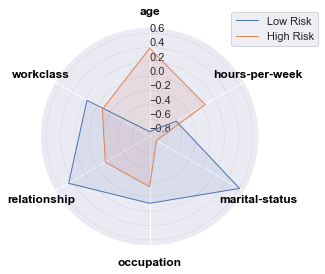

In [165]:
#Plot
numbers_features = 6
features = profile_dataset.columns
bins =5
priv = 1
sens_attr = 'sex'
ascending = True

profile_dataset_result, ds_radarchart_result, categories = ut.plotProfiles(profile_dataset=profile_dataset, 
                                                               numbers_features=numbers_features, 
                                                               features=features, 
                                                               bins=bins, 
                                                               priv=priv, 
                                                               sens_attr=sens_attr, 
                                                               ascending=ascending)


In [46]:
ds_radarchart_result

,age,hours-per-week,marital-status,occupation,relationship,risk,workclass
bins,,,,,,,
1.0,-0.816151,-0.428572,0.628750,0.088156,0.479672,0.452978,0.170506
2.0,-0.051536,0.088802,0.122689,-0.034699,-0.041602,0.549297,-0.103535
3.0,0.191093,0.139633,0.078318,0.077866,-0.078806,0.600379,-0.001724
4.0,0.282187,0.148887,-0.097347,0.013532,-0.214652,0.656098,0.015880
5.0,0.393332,0.051111,-0.730415,-0.144459,-0.144218,0.738669,-0.080905


In [37]:
pd.pivot_table(profile_dataset_result, values=['sex'], index=['bins'])

,sex
bins,
1.0,0.666439
2.0,0.666439
3.0,0.666439
4.0,0.666439
5.0,0.665986


In [38]:
profile_dataset_result

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass,marital-status,occupation,relationship,race,native-country,sex,bins,risk,label
13235,-0.628283,1.531625,12.838442,-0.224849,-0.025500,1.603707,1.588764,-1.044250,-0.275665,0.389497,0.248849,1,1.0,0.197813,1
5627,-0.555641,1.531625,12.838442,-0.224849,-0.025500,-0.260070,0.922284,-0.814171,-0.275665,0.389497,0.248849,0,1.0,0.224670,1
10538,-0.555641,1.139123,1.718922,-0.224849,0.774092,-0.260070,0.922284,-0.814171,-0.275665,0.389497,0.248849,0,1.0,0.235907,1
12167,0.316065,1.924128,12.838442,-0.224849,-0.025500,-0.260070,0.255803,0.566302,-0.275665,0.389497,0.248849,1,1.0,0.237385,1
14309,1.042487,1.924128,3.469381,-0.224849,-0.025500,0.982448,0.922284,0.566302,-0.275665,-3.172369,-1.247071,1,1.0,0.246378,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8501,0.751918,-0.430888,-0.143181,-0.224849,-0.185418,-0.260070,-1.743638,-1.504408,1.592374,0.389497,0.248849,0,5.0,0.861245,0
7884,0.824560,-0.038385,-0.143181,-0.224849,-0.025500,-0.260070,-1.743638,-1.504408,1.592374,0.389497,0.248849,0,5.0,0.861709,0
6686,1.115129,-0.430888,-0.143181,-0.224849,0.134419,-0.260070,-1.743638,-1.504408,1.592374,0.389497,0.248849,0,5.0,0.862062,0
6471,0.461349,-0.038385,-0.143181,-0.224849,-0.025500,-0.260070,-1.743638,-1.504408,1.592374,0.389497,0.248849,0,5.0,0.865513,0
